# Rendimento escolar nos municípios do Estado de São Paulo

### Bruna Lima Meinberg e Gustavo Mendes da Silva

#### Base: Taxas de Rendimento Escolar – INEP

**Como variam as taxas de aprovação, reprovação e abandono entre os municípios do estado de São Paulo, considerando diferentes etapas do ensino (Fundamental e Médio), e o que esses indicadores revelam sobre possíveis disparidades educacionais dentro do estado?**

**Importando bibliotecas**

In [97]:
# Manipulação de dados grandes
import dask.dataframe as dd

# Manipulação leve/auxiliar
import pandas as pd
import numpy as np

# Visualizações
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Configurações estéticas
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)




**Leitura do arquivo**

In [98]:
file_path = "data/tx_rend_municipios_2024.xlsx"

df = pd.read_excel(file_path, skiprows=8)

ddf = dd.from_pandas(df, npartitions=4)


Foi escolhido o dask para a construção desse notebook devido ao tamanho dos dados, mas principalmente para aplicação prática dos conteúdos vistos em aula

In [99]:
print("shape:", ddf.shape)
display(ddf.head(3))
display(ddf.columns.tolist())

shape: (<dask_expr.expr.Scalar: expr=df.size() // 61, dtype=int64>, 61)


,NU_ANO_CENSO,NO_REGIAO,SG_UF,CO_MUNICIPIO,NO_MUNICIPIO,NO_CATEGORIA,NO_DEPENDENCIA,1_CAT_FUN,1_CAT_FUN_AI,1_CAT_FUN_AF,...,3_CAT_FUN_06,3_CAT_FUN_07,3_CAT_FUN_08,3_CAT_FUN_09,3_CAT_MED,3_CAT_MED_01,3_CAT_MED_02,3_CAT_MED_03,3_CAT_MED_04,3_CAT_MED_NS
0,2024,Norte,RO,1100015.0,Alta Floresta D'Oeste,Total,Total,96.8,97.1,96.5,...,0.3,0.3,0,0.3,0.4,0.5,0.5,0,--,--
1,2024,Norte,RO,1100015.0,Alta Floresta D'Oeste,Urbana,Total,97.1,96.8,97.4,...,0.4,0.4,0,0.4,0.5,0.6,0.6,0,--,--
2,2024,Norte,RO,1100015.0,Alta Floresta D'Oeste,Rural,Total,96.3,97.6,94.9,...,0,0,0,0,0,0,0,0,--,--


['NU_ANO_CENSO',
 'NO_REGIAO',
 'SG_UF',
 'CO_MUNICIPIO',
 'NO_MUNICIPIO',
 'NO_CATEGORIA',
 'NO_DEPENDENCIA',
 '1_CAT_FUN',
 '1_CAT_FUN_AI',
 '1_CAT_FUN_AF',
 '1_CAT_FUN_01',
 '1_CAT_FUN_02',
 '1_CAT_FUN_03',
 '1_CAT_FUN_04',
 '1_CAT_FUN_05',
 '1_CAT_FUN_06',
 '1_CAT_FUN_07',
 '1_CAT_FUN_08',
 '1_CAT_FUN_09',
 '1_CAT_MED',
 '1_CAT_MED_01',
 '1_CAT_MED_02',
 '1_CAT_MED_03',
 '1_CAT_MED_04',
 '1_CAT_MED_NS',
 '2_CAT_FUN',
 '2_CAT_FUN_AI',
 '2_CAT_FUN_AF',
 '2_CAT_FUN_01',
 '2_CAT_FUN_02',
 '2_CAT_FUN_03',
 '2_CAT_FUN_04',
 '2_CAT_FUN_05',
 '2_CAT_FUN_06',
 '2_CAT_FUN_07',
 '2_CAT_FUN_08',
 '2_CAT_FUN_09',
 '2_CAT_MED',
 '2_CAT_MED_01',
 '2_CAT_MED_02',
 '2_CAT_MED_03',
 '2_CAT_MED_04',
 '2_CAT_MED_NS',
 '3_CAT_FUN',
 '3_CAT_FUN_AI',
 '3_CAT_FUN_AF',
 '3_CAT_FUN_01',
 '3_CAT_FUN_02',
 '3_CAT_FUN_03',
 '3_CAT_FUN_04',
 '3_CAT_FUN_05',
 '3_CAT_FUN_06',
 '3_CAT_FUN_07',
 '3_CAT_FUN_08',
 '3_CAT_FUN_09',
 '3_CAT_MED',
 '3_CAT_MED_01',
 '3_CAT_MED_02',
 '3_CAT_MED_03',
 '3_CAT_MED_04',
 '3_CA

A base original do INEP contém informações de todos os municípios do Brasil, para todas as regiões, estados, dependências administrativas e etapas de ensino.
Como o objetivo do projeto é analisar exclusivamente o estado de São Paulo, nosso primeiro passo é filtrar a coluna SG_UF para manter apenas as linhas onde o valor é "SP".

Isso garante que:

- evitamos processar dados desnecessários, deixando a análise mais leve;

- todas as visualizações e estatísticas se concentram apenas no contexto paulista, como definido na questão de pesquisa;

- eliminamos ruídos de municípios de outros estados.

A tabela contém mais de 60 colunas, mas nem todas são necessárias para este projeto. Vamos selecionar somente as colunas que têm informação útil para análise do rendimento escolar:

1. Informações de identificação do município

**CO_MUNICIPIO** — código IBGE do município (permite agregações consistentes)

**NO_MUNICIPIO** — nome do município

Essas colunas permitem identificar cada observação corretamente e comparar municípios dentro do estado.

2. Informações organizacionais

**NO_CATEGORIA** — categoria (ex.: Urbano / Total)

**NO_DEPENDENCIA** — tipo de rede administrativa
(ex.: Municipal, Estadual, Federal, Privada)

Essas variáveis são importantes para:

- comparar o desempenho entre redes (ex.: Estadual × Municipal)

- identificar diferenças entre áreas urbanas, rurais ou totais

- fazer análises estratificadas

3. Colunas de rendimento escolar (principais indicadores)

Essas colunas começam com:

**1_** → Taxas de aprovação

**2_** → Taxas de reprovação

**3_** → Taxas de abandono

E aparecem em diferentes recortes, como:

- Total

- Anos iniciais

- Anos finais

- Por série (1º ao 9º ano)

- Ensino médio (1ª, 2ª, 3ª série)

Essas são as variáveis centrais do projeto — toda a análise de desempenho, rankings, tendências e comparações é feita usando esses valores.

Portanto, selecionamos todas as colunas que começam com 1_, 2_ ou 3_.

As colunas de taxas de rendimento escolar (todas que começam com 1_, 2_ e 3_) contêm valores numéricos representando percentuais, mas a base original do INEP inclui valores como:

- **"--"**

- **"."**

- **"0 "**

- valores com vírgula ("97,1")

- strings não numéricas

Esses formatos impedem que o Python trate as colunas como números reais.
Por isso, antes de iniciarmos qualquer análise, precisamos padronizar as taxas.

Nesta etapa, vamos:

1. Identificar automaticamente todas as colunas de taxa

(prefixos 1_, 2_, 3_ conforme definido pelo INEP)

2. Substituir valores especiais por valores nulos (NaN)

Isso é importante porque NaN não atrapalha cálculos estatísticos.

3. Converter todas as colunas de taxa para tipo numérico (float)

Aplicando:

- substituição de vírgula por ponto

- coerção segura (errors="coerce")

4. Validar a conversão, mostrando estatísticas descritivas

Assim confirmamos que os valores foram reconhecidos corretamente.

Essa limpeza garante que os próximos passos — como criar rankings, gráficos e mapas — funcionem sem erros.

In [100]:
# ---------------------------------------
# Filtrar SP com segurança e diagnóstico
# ---------------------------------------

# 1. Normalizar SG_UF para uppercase
ddf["SG_UF"] = ddf["SG_UF"].astype(str).str.strip().str.upper()

# 2. Filtrar SP (lazy)
ddf_sp = ddf[ddf["SG_UF"] == "SP"]

# 3. Diagnóstico - contar linhas
print("Contando linhas SP (compute)...")
n_sp = ddf_sp.shape[0].compute()
print("Número de linhas com SG_UF == 'SP':", n_sp)

# 4. Mostrar primeiras linhas (agora computadas)
print("\nPreview de SP:")
df_sp = ddf_sp.compute()
df_sp.head()


Contando linhas SP (compute)...
Número de linhas com SG_UF == 'SP': 6703

Preview de SP:


,NU_ANO_CENSO,NO_REGIAO,SG_UF,CO_MUNICIPIO,NO_MUNICIPIO,NO_CATEGORIA,NO_DEPENDENCIA,1_CAT_FUN,1_CAT_FUN_AI,1_CAT_FUN_AF,...,3_CAT_FUN_06,3_CAT_FUN_07,3_CAT_FUN_08,3_CAT_FUN_09,3_CAT_MED,3_CAT_MED_01,3_CAT_MED_02,3_CAT_MED_03,3_CAT_MED_04,3_CAT_MED_NS
40160,2024,Sudeste,SP,3500105.0,Adamantina,Total,Total,99.5,99.7,99.3,...,0.2,0.5,0,0.7,8.6,6,8.5,11.9,--,--
40161,2024,Sudeste,SP,3500105.0,Adamantina,Urbana,Total,99.5,99.7,99.3,...,0.2,0.5,0,0.7,9.4,6.7,8.9,12.7,--,--
40162,2024,Sudeste,SP,3500105.0,Adamantina,Rural,Total,--,--,--,...,--,--,--,--,0,0,0,0,--,--
40163,2024,Sudeste,SP,3500105.0,Adamantina,Total,Estadual,99.4,--,99.4,...,0.4,0.8,0,1.1,10.7,7.6,10.6,14.4,--,--
40164,2024,Sudeste,SP,3500105.0,Adamantina,Urbana,Estadual,99.4,--,99.4,...,0.4,0.8,0,1.1,11.8,8.9,11.3,15.7,--,--


In [101]:

# 1. Remover colunas redundantes
cols_to_drop = ["NU_ANO_CENSO", "SG_UF", "NO_REGIAO"]
df_sp = ddf_sp.drop(columns=[c for c in cols_to_drop if c in ddf_sp.columns], errors="ignore")

# 2. Remover linhas totalmente vazias
df_sp = df_sp.dropna(how="all")

# 3. Normalizar NO_CATEGORIA e NO_DEPENDENCIA
df_sp["NO_CATEGORIA"] = df_sp["NO_CATEGORIA"].astype(str).str.strip().str.lower()
df_sp["NO_DEPENDENCIA"] = df_sp["NO_DEPENDENCIA"].astype(str).str.strip().str.lower()

# 4. IDENTIFICAR COLUNAS DE TAXA (1_,2_,3_)
tax_cols = [c for c in df_sp.columns if c.startswith(("1_", "2_", "3_"))]

# 5. LIMPEZA DAS TAXAS **NO LUGAR CERTO**
def clean_partition(pdf):
    special_values = ["--", "...", ".", "-", "—", "", " ", "NA", "N/A"]
    
    # substituir lixo por NaN
    pdf[tax_cols] = pdf[tax_cols].replace(special_values, np.nan)
    
    # trocar vírgula -> ponto
    pdf[tax_cols] = pdf[tax_cols].apply(lambda col: col.astype(str).str.replace(",", ".", regex=False))
    
    # converter pra float
    pdf[tax_cols] = pdf[tax_cols].apply(lambda col: pd.to_numeric(col, errors="coerce"))
    
    return pdf

# Apply cleaning (THIS IS THE CORRECT POINT)
df_sp = df_sp.map_partitions(clean_partition)

# 6. AGORA SIM: filtrar Total/Total no df_sp LIMPO
df_mun = df_sp[
    (df_sp["NO_CATEGORIA"] == "total") &
    (df_sp["NO_DEPENDENCIA"] == "total")
]

# 7. Remover colunas de categoria
df_mun = df_mun.drop(columns=["NO_CATEGORIA", "NO_DEPENDENCIA"], errors="ignore")

# 8. Remover duplicatas
df_mun = df_mun.drop_duplicates(subset=["CO_MUNICIPIO"])

# 9. Materializar dataframe final
df_mun_clean = df_mun.compute()



### Base final montada

In [102]:
print("Linhas finais:", df_mun_clean.shape)
df_mun_clean.head()

Linhas finais: (645, 56)


,CO_MUNICIPIO,NO_MUNICIPIO,1_CAT_FUN,1_CAT_FUN_AI,1_CAT_FUN_AF,1_CAT_FUN_01,1_CAT_FUN_02,1_CAT_FUN_03,1_CAT_FUN_04,1_CAT_FUN_05,...,3_CAT_FUN_06,3_CAT_FUN_07,3_CAT_FUN_08,3_CAT_FUN_09,3_CAT_MED,3_CAT_MED_01,3_CAT_MED_02,3_CAT_MED_03,3_CAT_MED_04,3_CAT_MED_NS
40160,3500105.0,Adamantina,99.5,99.7,99.3,99.7,100.0,99.8,99.7,99.5,...,0.2,0.5,0.0,0.7,8.6,6.0,8.5,11.9,NaN,NaN
40181,3500303.0,Aguaí,98.0,98.6,97.3,100.0,99.5,96.4,97.7,99.5,...,1.4,0.2,1.5,0.4,5.9,7.6,6.2,3.3,NaN,NaN
40215,3500550.0,Águas de Santa Bárbara,98.3,99.8,96.2,100.0,100.0,100.0,98.7,100.0,...,0.0,0.0,0.0,2.4,4.8,8.6,4.9,2.2,NaN,NaN
40231,3500709.0,Agudos,97.2,97.4,96.9,99.4,99.1,91.8,99.4,98.0,...,1.5,1.1,1.2,4.9,5.2,5.3,5.5,4.8,NaN,NaN
40258,3500907.0,Altair,98.4,100.0,96.6,100.0,100.0,100.0,100.0,100.0,...,1.9,0.0,2.4,2.3,0.0,0.0,0.0,0.0,NaN,NaN


In [103]:
df_mun_clean.describe()

,CO_MUNICIPIO,1_CAT_FUN,1_CAT_FUN_AI,1_CAT_FUN_AF,1_CAT_FUN_01,1_CAT_FUN_02,1_CAT_FUN_03,1_CAT_FUN_04,1_CAT_FUN_05,1_CAT_FUN_06,...,3_CAT_FUN_06,3_CAT_FUN_07,3_CAT_FUN_08,3_CAT_FUN_09,3_CAT_MED,3_CAT_MED_01,3_CAT_MED_02,3_CAT_MED_03,3_CAT_MED_04,3_CAT_MED_NS
count,6.450000e+02,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,...,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,16.000000,49.000000
mean,3.528698e+06,98.603256,99.112558,97.992713,99.706667,99.297209,98.014574,99.294109,99.328217,98.392713,...,0.276744,0.371163,0.584186,0.919225,2.482791,2.413333,2.760930,2.146512,0.775000,0.740816
std,1.670033e+04,1.397560,1.239520,1.992211,0.726988,1.833181,3.188796,1.662660,1.351573,2.545669,...,0.543469,0.660984,0.937867,1.264826,1.980377,2.480522,2.652772,2.360849,2.071553,2.924246
min,3.500105e+06,90.500000,92.700000,83.600000,92.400000,81.300000,80.000000,78.600000,88.700000,76.900000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.514601e+06,98.200000,98.800000,97.300000,99.800000,99.500000,97.200000,99.400000,99.200000,97.800000,...,0.000000,0.000000,0.000000,0.000000,0.900000,0.000000,0.500000,0.000000,0.000000,0.000000
50%,3.528700e+06,99.000000,99.600000,98.400000,100.000000,100.000000,99.500000,100.000000,100.000000,99.200000,...,0.000000,0.000000,0.200000,0.500000,2.100000,1.800000,2.200000,1.600000,0.000000,0.000000
75%,3.543204e+06,99.500000,100.000000,99.400000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,0.300000,0.500000,0.900000,1.300000,3.700000,3.500000,4.200000,3.200000,0.000000,0.000000
max,3.557303e+06,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,4.300000,4.700000,7.500000,10.000000,10.200000,16.700000,15.100000,12.400000,7.900000,18.300000


## Estatísticas Descritivas Iniciais — Entendendo o Panorama Geral

#### Estrutura da base final

Após filtrar o estado de São Paulo (SG_UF == "SP") e selecionar as observações agregadas por município
(`NO_CATEGORIA == "total"` e `NO_DEPENDENCIA == "total"`), cada município aparece com **uma única linha**.
Isso garante que as comparações entre municípios sejam diretas.

Importante: **essa agregação por município não remove as colunas de recorte por série/etapa**.
Ou seja, embora exista uma único registro por município (Total/Total), o dataframe preserva todas as
colunas de taxa (aprovação, reprovação e abandono) em vários recortes:
- totais por etapa (`1_CAT_FUN`, `1_CAT_MED`, `2_CAT_FUN`, `3_CAT_FUN`, etc.),  
- anos iniciais / anos finais (`*_AI`, `*_AF`),  
- por série (`*_01`, `*_02`, ..., `*_09`),  
- e as variantes para o ensino médio (`*_MED_*`).

Portanto, o dataframe final contém ~56 colunas: identificação do município + todas as taxas (total + recortes).
Isso permite análises tanto sobre os indicadores "totais" (p.ex. `1_CAT_FUN`) quanto sobre recortes finos
(p.ex. `1_CAT_FUN_03` ou `3_CAT_MED_02`), dependendo da pergunta analítica.


### A) Estatísticas descritivas iniciais

Objetivo: entender distribuição das taxas (aprovação/reprovação/abandono)
para todos os recortes disponíveis. Vamos gerar resumo (count, mean, std, min, 25%, 50%, 75%, max)
para todas as colunas que começam com 1_, 2_ ou 3_.


In [104]:

# Parte 1: identificar colunas de taxa
tax_cols = [c for c in df_mun_clean.columns if c.startswith(("1_", "2_", "3_"))]
print(f"Total de colunas de taxa detectadas: {len(tax_cols)}")
print("Exemplo (primeiras 12):", tax_cols[:12])

# Parte 2: estatísticas descritivas completas
stats = df_mun_clean[tax_cols].describe().T
display(stats)   # count, mean, std, min, 25%, 50%, 75%, max

# Parte 3: contagem de NaNs por coluna (ajuda a identificar recortes incompletos)
nan_counts = df_mun_clean[tax_cols].isna().sum().sort_values(ascending=False)
print("\nTop 15 colunas com mais NaNs (se houver):")
display(nan_counts.head(15))

# Parte 4: min/max por indicador para rápida checagem
minmax = df_mun_clean[tax_cols].agg(["min","max"]).T
display(minmax.head(20))


Total de colunas de taxa detectadas: 54
Exemplo (primeiras 12): ['1_CAT_FUN', '1_CAT_FUN_AI', '1_CAT_FUN_AF', '1_CAT_FUN_01', '1_CAT_FUN_02', '1_CAT_FUN_03', '1_CAT_FUN_04', '1_CAT_FUN_05', '1_CAT_FUN_06', '1_CAT_FUN_07', '1_CAT_FUN_08', '1_CAT_FUN_09']


,count,mean,std,min,25%,50%,75%,max
1_CAT_FUN,645.0,98.603256,1.397560,90.5,98.200,99.0,99.50,100.0
1_CAT_FUN_AI,645.0,99.112558,1.239520,92.7,98.800,99.6,100.00,100.0
1_CAT_FUN_AF,645.0,97.992713,1.992211,83.6,97.300,98.4,99.40,100.0
1_CAT_FUN_01,645.0,99.706667,0.726988,92.4,99.800,100.0,100.00,100.0
1_CAT_FUN_02,645.0,99.297209,1.833181,81.3,99.500,100.0,100.00,100.0
1_CAT_FUN_03,645.0,98.014574,3.188796,80.0,97.200,99.5,100.00,100.0
1_CAT_FUN_04,645.0,99.294109,1.662660,78.6,99.400,100.0,100.00,100.0
1_CAT_FUN_05,645.0,99.328217,1.351573,88.7,99.200,100.0,100.00,100.0
1_CAT_FUN_06,645.0,98.392713,2.545669,76.9,97.800,99.2,100.00,100.0
1_CAT_FUN_07,645.0,98.322636,2.386234,83.3,97.900,99.0,100.00,100.0



Top 15 colunas com mais NaNs (se houver):


3_CAT_MED_04    629
2_CAT_MED_04    629
1_CAT_MED_04    629
3_CAT_MED_NS    596
2_CAT_MED_NS    596
1_CAT_MED_NS    596
3_CAT_FUN_01      0
2_CAT_MED         0
2_CAT_MED_01      0
2_CAT_MED_02      0
2_CAT_MED_03      0
3_CAT_FUN         0
3_CAT_FUN_AI      0
3_CAT_FUN_AF      0
3_CAT_FUN_02      0
dtype: int64

,min,max
1_CAT_FUN,90.5,100.0
1_CAT_FUN_AI,92.7,100.0
1_CAT_FUN_AF,83.6,100.0
1_CAT_FUN_01,92.4,100.0
1_CAT_FUN_02,81.3,100.0
1_CAT_FUN_03,80.0,100.0
1_CAT_FUN_04,78.6,100.0
1_CAT_FUN_05,88.7,100.0
1_CAT_FUN_06,76.9,100.0
1_CAT_FUN_07,83.3,100.0


### B) Top10 e Bottom10 de municípios

Vamos gerar rankings por:
- Aprovação Fundamental total (`1_CAT_FUN`) — principal métrica de aprovação no ensino fundamental
- Aprovação Médio total (`1_CAT_MED`) — principal métrica de aprovação no ensino médio

Para cada métrica: Top 10 (maiores taxas) e Bottom 10 (menores taxas). Além das tabelas, geramos gráficos.


In [105]:
df_mun_clean["1_CAT_FUN"].describe()


count    645.000000
mean      98.603256
std        1.397560
min       90.500000
25%       98.200000
50%       99.000000
75%       99.500000
max      100.000000
Name: 1_CAT_FUN, dtype: float64

In [106]:
# garantir que df_mun_clean exista
df_mun_clean = df_mun.compute()

# Colunas principais confirmadas
aprov_fun_col = "1_CAT_FUN"
aprov_med_col = "1_CAT_MED"

# Segurança: verificar presença das colunas
for col in (aprov_fun_col, aprov_med_col):
    if col not in df_mun_clean.columns:
        raise KeyError(f"Coluna esperada não encontrada: {col}")

# --- Top/Bottom para Ensino Fundamental (1_CAT_FUN)
top10_fun = df_mun_clean.sort_values(by=aprov_fun_col, ascending=False).head(10)
bottom10_fun = df_mun_clean.sort_values(by=aprov_fun_col, ascending=True).head(10)

print("Top 10 - Aprovação (Ensino Fundamental):")
display(top10_fun[["CO_MUNICIPIO", "NO_MUNICIPIO", aprov_fun_col]])

print("\nBottom 10 - Aprovação (Ensino Fundamental):")
display(bottom10_fun[["CO_MUNICIPIO", "NO_MUNICIPIO", aprov_fun_col]])

# Plot – Top 10 Fundamental
fig = px.bar(
    top10_fun,
    x="NO_MUNICIPIO",
    y=aprov_fun_col,
    title="Top 10 - Taxa de Aprovação (Ensino Fundamental)",
    labels={aprov_fun_col: "Aprovação (%)"}
)
fig.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(range=[0, 100])
)
fig.show()

# Plot – Bottom 10 Fundamental
fig = px.bar(
    bottom10_fun,
    x="NO_MUNICIPIO",
    y=aprov_fun_col,
    title="Bottom 10 - Taxa de Aprovação (Ensino Fundamental)",
    labels={aprov_fun_col: "Aprovação (%)"}
)
fig.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(range=[0, 100])
)
fig.show()


# --- Top/Bottom para Ensino Médio (1_CAT_MED)
top10_med = df_mun_clean.sort_values(by=aprov_med_col, ascending=False).head(10)
bottom10_med = df_mun_clean.sort_values(by=aprov_med_col, ascending=True).head(10)

print("Top 10 - Aprovação (Ensino Médio):")
display(top10_med[["CO_MUNICIPIO", "NO_MUNICIPIO", aprov_med_col]])

print("\nBottom 10 - Aprovação (Ensino Médio):")
display(bottom10_med[["CO_MUNICIPIO", "NO_MUNICIPIO", aprov_med_col]])

# Plot – Top 10 Médio
fig = px.bar(
    top10_med,
    x="NO_MUNICIPIO",
    y=aprov_med_col,
    title="Top 10 - Taxa de Aprovação (Ensino Médio)",
    labels={aprov_med_col: "Aprovação (%)"}
)
fig.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(range=[0, 100])
)
fig.show()

# Plot – Bottom 10 Médio
fig = px.bar(
    bottom10_med,
    x="NO_MUNICIPIO",
    y=aprov_med_col,
    title="Bottom 10 - Taxa de Aprovação (Ensino Médio)",
    labels={aprov_med_col: "Aprovação (%)"}
)
fig.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(range=[0, 100])
)
fig.show()


Top 10 - Aprovação (Ensino Fundamental):


,CO_MUNICIPIO,NO_MUNICIPIO,1_CAT_FUN
46611,3555307.0,Turmalina,100.0
41724,3513306.0,Cruzália,100.0
42129,3516507.0,Gabriel Monteiro,100.0
42648,3520806.0,Inúbia Paulista,100.0
45472,3545605.0,Santa Adélia,100.0
42064,3515806.0,Flora Rica,100.0
41995,3515301.0,Estrela do Norte,100.0
45673,3547650.0,Santa Salete,100.0
41389,3510104.0,Cândido Rodrigues,100.0
44926,3540853.0,Pracinha,100.0



Bottom 10 - Aprovação (Ensino Fundamental):


,CO_MUNICIPIO,NO_MUNICIPIO,1_CAT_FUN
43849,3531209.0,Monte Alegre do Sul,90.5
45709,3548005.0,Santo Antônio de Posse,91.5
44295,3535200.0,Palmeira d'Oeste,92.3
40173,3500204.0,Adolfo,92.7
43129,3524907.0,Jambeiro,93.0
40205,3500501.0,Águas de Lindóia,93.2
40430,3502507.0,Aparecida,93.3
45893,3549508.0,São José da Bela Vista,93.4
43914,3531803.0,Monte Mor,93.5
46540,3554755.0,Trabiju,93.7


Top 10 - Aprovação (Ensino Médio):


,CO_MUNICIPIO,NO_MUNICIPIO,1_CAT_MED
44476,3536802.0,Pedra Bela,100.0
46570,3554953.0,Tuiuti,100.0
44487,3536901.0,Pedranópolis,100.0
43408,3527256.0,Lourdes,100.0
41389,3510104.0,Cândido Rodrigues,100.0
45377,3544707.0,Sagres,100.0
41724,3513306.0,Cruzália,100.0
41985,3515202.0,Estrela d'Oeste,100.0
43497,3528205.0,Macedônia,100.0
42394,3518909.0,Guzolândia,100.0



Bottom 10 - Aprovação (Ensino Médio):


,CO_MUNICIPIO,NO_MUNICIPIO,1_CAT_MED
42228,3517505.0,Guapiaçu,79.9
46649,3555604.0,Uchoa,81.7
46114,3551207.0,Sarutaiá,82.9
44394,3536109.0,Pardinho,83.6
46733,3556404.0,Vargem Grande do Sul,83.9
40440,3502606.0,Aparecida d'Oeste,84.4
44908,3540754.0,Potim,84.5
44868,3540408.0,Populina,84.8
44295,3535200.0,Palmeira d'Oeste,85.3
45893,3549508.0,São José da Bela Vista,85.3



Agora vamos gerar rankings por:
- Reprovação Fundamental total (`2_CAT_FUN`) — principal métrica de reprovação no ensino fundamental
- Reprovação Médio total (`2_CAT_MED`) — principal métrica de reprovação no ensino médio

Para cada métrica: Top 10 (maiores taxas) e Bottom 10 (menores taxas). Além das tabelas, geramos gráficos.

In [107]:
# --- REPROVAÇÃO (Fundamental e Médio) ---
# garantir df_mun_clean
df_mun_clean = df_mun.compute()

# Colunas
reprov_fun_col = "2_CAT_FUN"
reprov_med_col = "2_CAT_MED"

# Segurança: verificar presença
for col in (reprov_fun_col, reprov_med_col):
    if col not in df_mun_clean.columns:
        raise KeyError(f"Coluna esperada não encontrada: {col}")

# remover NaN antes de ordenar
df_reprov = df_mun_clean.dropna(subset=[reprov_fun_col, reprov_med_col], how='all')

# Top/Bottom Fundamental
top10_reprov_fun = df_reprov.sort_values(by=reprov_fun_col, ascending=False).head(10)
bottom10_reprov_fun = df_reprov.sort_values(by=reprov_fun_col, ascending=True).head(10)

print("Top 10 - Reprovação (Ensino Fundamental):")
display(top10_reprov_fun[["CO_MUNICIPIO","NO_MUNICIPIO", reprov_fun_col]])

print("\nBottom 10 - Reprovação (Ensino Fundamental):")
display(bottom10_reprov_fun[["CO_MUNICIPIO","NO_MUNICIPIO", reprov_fun_col]])

# Plots (eixo Y 0-20 para realçar variações)
fig = px.bar(top10_reprov_fun, x="NO_MUNICIPIO", y=reprov_fun_col,
             title="Top 10 - Reprovação (Fundamental)",
             labels={reprov_fun_col:"Reprovação (%)"})
fig.update_layout(xaxis_tickangle=-45, yaxis=dict(range=[0,20]))
fig.show()

fig = px.bar(bottom10_reprov_fun, x="NO_MUNICIPIO", y=reprov_fun_col,
             title="Bottom 10 - Reprovação (Fundamental)",
             labels={reprov_fun_col:"Reprovação (%)"})
fig.update_layout(xaxis_tickangle=-45, yaxis=dict(range=[0,20]))
fig.show()

# Top/Bottom Médio
top10_reprov_med = df_reprov.sort_values(by=reprov_med_col, ascending=False).head(10)
bottom10_reprov_med = df_reprov.sort_values(by=reprov_med_col, ascending=True).head(10)

print("Top 10 - Reprovação (Ensino Médio):")
display(top10_reprov_med[["CO_MUNICIPIO","NO_MUNICIPIO", reprov_med_col]])

print("\nBottom 10 - Reprovação (Ensino Médio):")
display(bottom10_reprov_med[["CO_MUNICIPIO","NO_MUNICIPIO", reprov_med_col]])

fig = px.bar(top10_reprov_med, x="NO_MUNICIPIO", y=reprov_med_col,
             title="Top 10 - Reprovação (Médio)",
             labels={reprov_med_col:"Reprovação (%)"})
fig.update_layout(xaxis_tickangle=-45, yaxis=dict(range=[0,20]))
fig.show()

fig = px.bar(bottom10_reprov_med, x="NO_MUNICIPIO", y=reprov_med_col,
             title="Bottom 10 - Reprovação (Médio)",
             labels={reprov_med_col:"Reprovação (%)"})
fig.update_layout(xaxis_tickangle=-45, yaxis=dict(range=[0,20]))
fig.show()


Top 10 - Reprovação (Ensino Fundamental):


,CO_MUNICIPIO,NO_MUNICIPIO,2_CAT_FUN
43849,3531209.0,Monte Alegre do Sul,9.5
45709,3548005.0,Santo Antônio de Posse,8.4
40173,3500204.0,Adolfo,7.3
43129,3524907.0,Jambeiro,7.0
44295,3535200.0,Palmeira d'Oeste,7.0
40205,3500501.0,Águas de Lindóia,6.7
45893,3549508.0,São José da Bela Vista,6.6
40430,3502507.0,Aparecida,6.5
46540,3554755.0,Trabiju,6.3
43914,3531803.0,Monte Mor,6.1



Bottom 10 - Reprovação (Ensino Fundamental):


,CO_MUNICIPIO,NO_MUNICIPIO,2_CAT_FUN
46611,3555307.0,Turmalina,0.0
42796,3522158.0,Itaoca,0.0
45673,3547650.0,Santa Salete,0.0
43209,3525607.0,João Ramalho,0.0
45611,3547007.0,Santa Maria da Serra,0.0
45563,3546504.0,Santa Ernestina,0.0
43463,3527801.0,Lupércio,0.0
45472,3545605.0,Santa Adélia,0.0
43605,3529104.0,Marinópolis,0.0
44059,3532868.0,Nova Castilho,0.0


Top 10 - Reprovação (Ensino Médio):


,CO_MUNICIPIO,NO_MUNICIPIO,2_CAT_MED
46649,3555604.0,Uchoa,15.1
44394,3536109.0,Pardinho,14.6
42228,3517505.0,Guapiaçu,13.3
45067,3541901.0,Queluz,13.2
40440,3502606.0,Aparecida d'Oeste,12.5
46733,3556404.0,Vargem Grande do Sul,12.3
43757,3530409.0,Mirassolândia,12.3
40414,3502309.0,Anhembi,11.3
42202,3517208.0,Guaiçara,11.1
42272,3517901.0,Guaraci,10.9



Bottom 10 - Reprovação (Ensino Médio):


,CO_MUNICIPIO,NO_MUNICIPIO,2_CAT_MED
40194,3500402.0,Águas da Prata,0.0
42907,3522901.0,Itapuí,0.0
42692,3521200.0,Iporanga,0.0
43048,3524204.0,Jaborandi,0.0
44672,3538600.0,Piracaia,0.0
43937,3532009.0,Morungaba,0.0
43084,3524501.0,Jaci,0.0
44023,3532702.0,Nipoã,0.0
44375,3535903.0,Paranapuã,0.0
41018,3507308.0,Boracéia,0.0


Visualmente, não é necessário manter tanto a análise baseado em aprovação e reprovação, visto que um é complementar do outro.


Agora vamos gerar rankings por:
- Abandono Fundamental total (`3_CAT_FUN`) — principal métrica de abandono no ensino fundamental
- Abandono Médio total (`2_CAT_MED`) — principal métrica de abandono no ensino médio

Para cada métrica: Top 10 (maiores taxas) e Bottom 10 (menores taxas). Além das tabelas, geramos gráficos.

In [108]:
# --- ABANDONO (Fundamental e Médio) ---
aband_fun_col = "3_CAT_FUN"
aband_med_col = "3_CAT_MED"

for col in (aband_fun_col, aband_med_col):
    if col not in df_mun_clean.columns:
        raise KeyError(f"Coluna esperada não encontrada: {col}")

df_aband = df_mun_clean.dropna(subset=[aband_fun_col, aband_med_col], how='all')

# Fundamental
top10_aband_fun = df_aband.sort_values(by=aband_fun_col, ascending=False).head(10)
bottom10_aband_fun = df_aband.sort_values(by=aband_fun_col, ascending=True).head(10)

print("Top 10 - Abandono (Ensino Fundamental):")
display(top10_aband_fun[["CO_MUNICIPIO","NO_MUNICIPIO", aband_fun_col]])

print("\nBottom 10 - Abandono (Ensino Fundamental):")
display(bottom10_aband_fun[["CO_MUNICIPIO","NO_MUNICIPIO", aband_fun_col]])

fig = px.bar(top10_aband_fun, x="NO_MUNICIPIO", y=aband_fun_col,
             title="Top 10 - Abandono (Fundamental)",
             labels={aband_fun_col:"Abandono (%)"})
fig.update_layout(xaxis_tickangle=-45, yaxis=dict(range=[0,20]))
fig.show()

fig = px.bar(bottom10_aband_fun, x="NO_MUNICIPIO", y=aband_fun_col,
             title="Bottom 10 - Abandono (Fundamental)",
             labels={aband_fun_col:"Abandono (%)"})
fig.update_layout(xaxis_tickangle=-45, yaxis=dict(range=[0,20]))
fig.show()

# Médio
top10_aband_med = df_aband.sort_values(by=aband_med_col, ascending=False).head(10)
bottom10_aband_med = df_aband.sort_values(by=aband_med_col, ascending=True).head(10)

print("Top 10 - Abandono (Ensino Médio):")
display(top10_aband_med[["CO_MUNICIPIO","NO_MUNICIPIO", aband_med_col]])

print("\nBottom 10 - Abandono (Ensino Médio):")
display(bottom10_aband_med[["CO_MUNICIPIO","NO_MUNICIPIO", aband_med_col]])

fig = px.bar(top10_aband_med, x="NO_MUNICIPIO", y=aband_med_col,
             title="Top 10 - Abandono (Médio)",
             labels={aband_med_col:"Abandono (%)"})
fig.update_layout(xaxis_tickangle=-45, yaxis=dict(range=[0,20]))
fig.show()

fig = px.bar(bottom10_aband_med, x="NO_MUNICIPIO", y=aband_med_col,
             title="Bottom 10 - Abandono (Médio)",
             labels={aband_med_col:"Abandono (%)"})
fig.update_layout(xaxis_tickangle=-45, yaxis=dict(range=[0,20]))
fig.show()


Top 10 - Abandono (Ensino Fundamental):


,CO_MUNICIPIO,NO_MUNICIPIO,3_CAT_FUN
45369,3544608.0,Sabino,2.5
46114,3551207.0,Sarutaiá,1.6
46130,3551405.0,Serra Azul,1.5
45261,3543600.0,Rifaina,1.5
43150,3525102.0,Jardinópolis,1.4
41667,3512704.0,Corumbataí,1.3
42210,3517307.0,Guaimbê,1.2
40194,3500402.0,Águas da Prata,1.2
44790,3539608.0,Planalto,1.2
46066,3550803.0,São Sebastião da Grama,1.2



Bottom 10 - Abandono (Ensino Fundamental):


,CO_MUNICIPIO,NO_MUNICIPIO,3_CAT_FUN
46611,3555307.0,Turmalina,0.0
46389,3553658.0,Taquaral,0.0
45867,3549250.0,São João de Iracema,0.0
45722,3548054.0,Santo Antônio do Aracanguá,0.0
40779,3505351.0,Barra do Chapéu,0.0
45619,3547106.0,Santa Mercedes,0.0
45532,3546256.0,Santa Cruz da Esperança,0.0
45513,3546108.0,Santa Clara d'Oeste,0.0
45500,3546009.0,Santa Branca,0.0
40963,3506904.0,Bofete,0.0


Top 10 - Abandono (Ensino Médio):


,CO_MUNICIPIO,NO_MUNICIPIO,3_CAT_MED
44633,3538105.0,Pindorama,10.2
45611,3547007.0,Santa Maria da Serra,9.4
45191,3543105.0,Ribeirão Corrente,8.8
40160,3500105.0,Adamantina,8.6
44908,3540754.0,Potim,8.6
42541,3520004.0,Igaraçu do Tietê,8.4
46471,3554201.0,Tejupá,8.2
41093,3507803.0,Brodowski,7.8
41572,3511706.0,Charqueada,7.5
42478,3519402.0,Ibirá,7.5



Bottom 10 - Abandono (Ensino Médio):


,CO_MUNICIPIO,NO_MUNICIPIO,3_CAT_MED
46611,3555307.0,Turmalina,0.0
40963,3506904.0,Bofete,0.0
41520,3511201.0,Catiguá,0.0
41904,3514924.0,Elisiário,0.0
41912,3514957.0,Embaúba,0.0
45482,3545704.0,Santa Albertina,0.0
43455,3527702.0,Luiziânia,0.0
43757,3530409.0,Mirassolândia,0.0
44023,3532702.0,Nipoã,0.0
44186,3534104.0,Oriente,0.0


### box plot

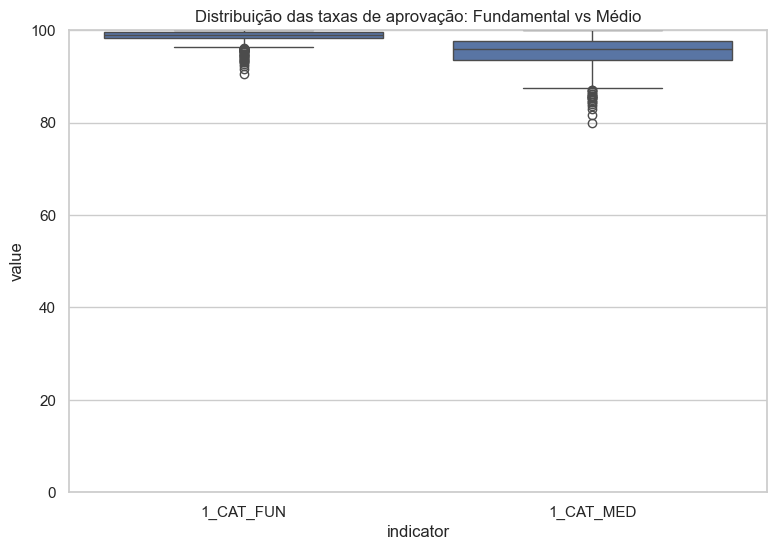

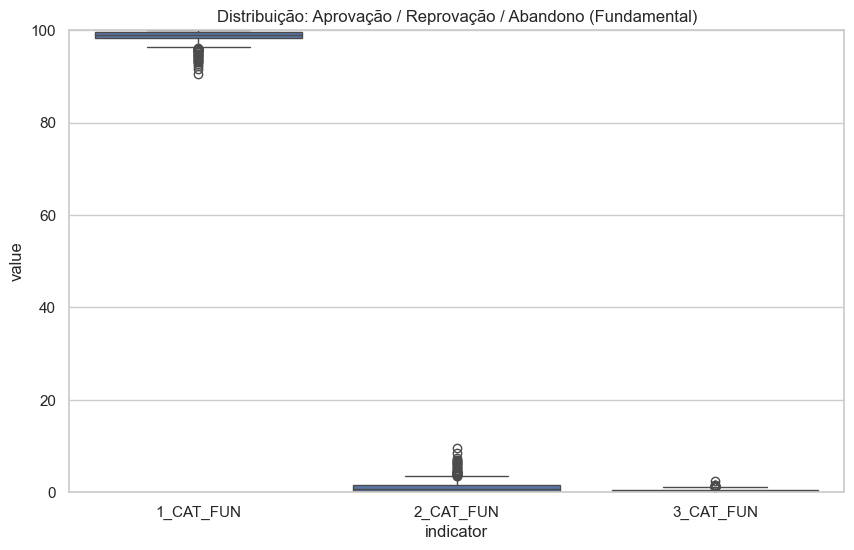

In [109]:
# --- BOXPLOTS ---
import matplotlib.pyplot as plt
import seaborn as sns

# A) Boxplot: Aprovação Fundamental x Médio (0-100)
plt.figure(figsize=(9,6))
sns.boxplot(data=df_mun_clean[["1_CAT_FUN","1_CAT_MED"]].melt(var_name="indicator", value_name="value"),
            x="indicator", y="value")
plt.ylim(0,100)
plt.title("Distribuição das taxas de aprovação: Fundamental vs Médio")
plt.show()

# B) Boxplot comparando 1_CAT_FUN, 2_CAT_FUN, 3_CAT_FUN (Fundamental) com eixo 0-20 para repro/aband
plt.figure(figsize=(10,6))
sns.boxplot(data=df_mun_clean[["1_CAT_FUN","2_CAT_FUN","3_CAT_FUN"]].melt(var_name="indicator", value_name="value"),
            x="indicator", y="value")
plt.ylim(0,100)   # se quiser focar em repro/aband use plt.ylim(0,20)
plt.title("Distribuição: Aprovação / Reprovação / Abandono (Fundamental)")
plt.show()


## Interpretação dos Resultados — Taxas de Abandono Escolar em São Paulo (2024)

Nesta seção interpretamos os resultados obtidos para as taxas de abandono escolar no estado de São Paulo, tanto no Ensino Fundamental quanto no Ensino Médio, considerando os valores presentes no conjunto de dados da Taxa de Rendimento Escolar do INEP (2024).

A análise é feita a partir dos rankings de top 10 (maiores índices) e bottom 10 (menores índices), referentes às colunas:

3_CAT_FUN → abandono total no Ensino Fundamental

3_CAT_MED → abandono total no Ensino Médio

1. Abandono no Ensino Fundamental — 3_CAT_FUN

Os resultados para os municípios do estado de São Paulo mostram que:

- Os maiores valores de abandono no Fundamental variam entre 1.2% e 2.5%.

- O município com maior abandono foi Sabino (2.5%), seguido por Sarutaiá, Serra Azul, Rifaina e Jardinópolis.

- A maior parte dos municípios do “Top 10” se concentra entre 1.2% e 1.5%, ou seja, valores muito baixos.

- Os municípios do “Bottom 10” registram abandono igual a 0.0%, incluindo:
Turmalina, Taquaral, Santa Clara d’Oeste, Santa Branca, Barra do Chapéu, entre outros.


O abandono escolar no Ensino Fundamental é baixo em todo o estado.
Mesmo os municípios com os piores resultados apresentam valores inferiores a 3%, o que caracteriza uma baixa evasão nessa etapa.

Isso indica:

- boa retenção das crianças nas escolas,

- políticas municipais de acompanhamento presentes,

- transporte escolar consolidado,

- obrigatoriedade legal de frequência escolar na infância.

Conclusão: O Ensino Fundamental apresenta alta estabilidade e baixa evasão no estado.

2. Abandono no Ensino Médio

Os resultados mostram um cenário muito mais crítico para o Ensino Médio:

- Os municípios com maior abandono apresentam índices entre 7.5% e 10.2%.

- O maior valor registrado foi em Pindorama (10.2%), seguido por Santa Maria da Serra (9.4%), Ribeirão Corrente (8.8%), Adamantina (8.6%) e Potim (8.6%).

- Os municípios com menor abandono foram Turmalina, Bofete, Catiguá, Embaúba, entre outros, todos com 0.0%.


A evasão no Ensino Médio é bem mais alta e desigual entre os municípios.
Alguns chegam a registrar abandonos superiores a 8–10%, indicando que:

- alunos mais velhos enfrentam maior risco de abandono,

- fatores socioeconômicos impactam fortemente essa etapa,

- o Ensino Médio é majoritariamente sob gestão estadual — diferenças de infraestrutura e contexto local impactam mais,

- deslocamento, trabalho precoce e falta de engajamento são fatores reais.

Conclusão: O Ensino Médio é a etapa mais vulnerável e desigual do estado. Há municípios com abandono 8 a 10 vezes maior do que no Fundamental.


## Segunda Análise: Comparação por Categoria (Urbana, Rural, Total) e Dependência (Municipal, Estadual)

Além da análise por município (usando apenas a linha Total/Total), o dataset do INEP 
também contém informações segmentadas por:

- **Categoria:** `urbana`, `rural` e `total`
- **Dependência administrativa:** `municipal`, `estadual`, `federal`, `privada`, `total`

Essa segmentação permite investigar **desigualdades internas dentro de cada município**, 
e entender como o desempenho educacional varia entre escolas urbanas, rurais e redes distintas.

Nesta seção vamos gerar:
- uma base separada contendo todas essas categorias,
- médias globais por categoria (SP inteiro),
- comparações diretas entre Urbana × Rural × Total,
- comparações entre Municipal × Estadual,
- análises por aprovação, reprovação e abandono.


In [110]:

df_full = df_sp.compute()  # materializamos aqui só para análise categoria/dependência

# Normalizar strings
df_full["NO_CATEGORIA"] = df_full["NO_CATEGORIA"].astype(str).str.strip().str.lower()
df_full["NO_DEPENDENCIA"] = df_full["NO_DEPENDENCIA"].astype(str).str.strip().str.lower()

# Criar subconjuntos
df_cat = df_full[["CO_MUNICIPIO","NO_MUNICIPIO","NO_CATEGORIA"] + [c for c in df_full.columns if c.startswith(("1_","2_","3_"))]].copy()
df_dep = df_full[["CO_MUNICIPIO","NO_MUNICIPIO","NO_DEPENDENCIA"] + [c for c in df_full.columns if c.startswith(("1_","2_","3_"))]].copy()

# Confirmar categorias existentes
print("Categorias encontradas:", df_cat["NO_CATEGORIA"].unique())
print("Dependências encontradas:", df_dep["NO_DEPENDENCIA"].unique())


Categorias encontradas: ['total' 'urbana' 'rural']
Dependências encontradas: ['total' 'estadual' 'municipal' 'privada' 'pública' 'federal']


In [111]:
# -----------------------------------
# Médias por categoria URBANA / RURAL / TOTAL
# -----------------------------------

tax_cols = [c for c in df_cat.columns if c.startswith(("1_","2_","3_"))]

avg_cat = df_cat.groupby("NO_CATEGORIA")[tax_cols].mean()

print("Médias das taxas por categoria (Fundamental e Médio):")
display(avg_cat)


Médias das taxas por categoria (Fundamental e Médio):


,1_CAT_FUN,1_CAT_FUN_AI,1_CAT_FUN_AF,1_CAT_FUN_01,1_CAT_FUN_02,1_CAT_FUN_03,1_CAT_FUN_04,1_CAT_FUN_05,1_CAT_FUN_06,1_CAT_FUN_07,...,3_CAT_FUN_06,3_CAT_FUN_07,3_CAT_FUN_08,3_CAT_FUN_09,3_CAT_MED,3_CAT_MED_01,3_CAT_MED_02,3_CAT_MED_03,3_CAT_MED_04,3_CAT_MED_NS
NO_CATEGORIA,,,,,,,,,,,,,,,,,,,,,
rural,98.414518,98.763444,98.065772,99.717302,99.160031,97.340566,99.240409,98.650866,98.100922,98.671724,...,0.172581,0.273103,0.450113,0.450230,1.195628,1.191643,1.481361,1.187798,NaN,0.281818
total,98.677730,99.170488,98.071683,99.710314,99.330876,98.188795,99.324411,99.350673,98.423354,98.363018,...,0.267578,0.353400,0.554383,0.853641,2.250110,2.201757,2.498902,1.948922,0.756,0.647059
urbana,98.669474,99.170935,98.047774,99.707699,99.321684,98.208539,99.320816,99.349618,98.397623,98.343614,...,0.272644,0.355676,0.559222,0.864112,2.289104,2.236516,2.557105,1.976828,0.756,0.905319


In [112]:
# -----------------------------------
# Médias por dependência administrativa
# -----------------------------------

avg_dep = df_dep.groupby("NO_DEPENDENCIA")[tax_cols].mean()

print("Médias das taxas por dependência (municipal vs estadual):")
display(avg_dep)


Médias das taxas por dependência (municipal vs estadual):


,1_CAT_FUN,1_CAT_FUN_AI,1_CAT_FUN_AF,1_CAT_FUN_01,1_CAT_FUN_02,1_CAT_FUN_03,1_CAT_FUN_04,1_CAT_FUN_05,1_CAT_FUN_06,1_CAT_FUN_07,...,3_CAT_FUN_06,3_CAT_FUN_07,3_CAT_FUN_08,3_CAT_FUN_09,3_CAT_MED,3_CAT_MED_01,3_CAT_MED_02,3_CAT_MED_03,3_CAT_MED_04,3_CAT_MED_NS
NO_DEPENDENCIA,,,,,,,,,,,,,,,,,,,,,
estadual,98.229955,99.406569,98.140468,99.578889,99.803543,98.581250,99.366794,99.697368,98.699636,98.897290,...,0.361202,0.497109,0.781441,1.183514,2.603416,2.561615,2.920344,2.257204,0.000000,0.358333
federal,97.600000,99.500000,96.600000,100.000000,100.000000,100.000000,100.000000,96.700000,100.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.454286,0.561765,0.347059,0.320588,1.066667,0.000000
municipal,98.771526,98.996317,97.053707,99.691945,99.193863,97.771938,99.210504,99.146451,97.087294,96.712126,...,0.246040,0.276578,0.440365,0.571595,1.656410,1.582353,1.683333,2.329730,0.000000,NaN
privada,99.538810,99.627620,99.422061,99.830312,99.587892,99.519318,99.698573,99.562340,99.414949,99.420000,...,0.006967,0.005294,0.002985,0.023404,0.036672,0.033786,0.057581,0.011360,0.000000,3.537500
pública,98.476949,99.011007,97.833567,99.690553,99.231582,97.816858,99.243088,99.208092,98.237676,98.212175,...,0.310634,0.411049,0.644554,0.974121,2.580299,2.529857,2.892699,2.246132,0.840000,0.351020
total,98.571732,99.061256,97.997073,99.705507,99.270979,97.929396,99.288591,99.229799,98.340922,98.350804,...,0.267668,0.362614,0.571269,0.874773,2.388031,2.326387,2.683250,2.080884,0.775000,0.765347


In [113]:
import plotly.express as px

fig = px.box(
    df_cat.dropna(subset=["1_CAT_FUN"]),
    x="NO_CATEGORIA",
    y="1_CAT_FUN",
    title="Aprovação – Fundamental (Urbana vs Rural vs Total)",
    labels={"1_CAT_FUN":"Aprovação (%)", "NO_CATEGORIA":"Categoria"}
)
fig.update_layout(yaxis=dict(range=[0,100]))
fig.show()


In [114]:
fig = px.box(
    df_cat.dropna(subset=["3_CAT_MED"]),
    x="NO_CATEGORIA",
    y="3_CAT_MED",
    title="Abandono – Ensino Médio (Urbana vs Rural vs Total)",
    labels={"3_CAT_MED":"Abandono (%)", "NO_CATEGORIA":"Categoria"}
)
fig.update_layout(yaxis=dict(range=[0,15]))
fig.show()


# Análise por Categoria (Urbana, Rural, Total) e por Dependência Administrativa

Depois de calcular as médias das taxas de aprovação, reprovação e abandono para cada categoria
territorial (urbana, rural, total) e cada dependência administrativa (municipal, estadual,
privada, pública, federal), podemos extrair um conjunto de conclusões claras sobre a estrutura
educacional do estado de São Paulo.

---

## 1) Comparação por Categoria: Urbana × Rural × Total

### Aprovação (1_*) — Urbana e Total praticamente iguais

Os valores médios de aprovação para as categorias **urbana** e **total** são praticamente
idênticos:

- **Urbana 1_CAT_FUN** ≈ 98.66%
- **Total 1_CAT_FUN** ≈ 98.67%
- **Rural 1_CAT_FUN** ≈ 98.41%

Isso mostra que:

- As escolas **urbanas e as agregadas (total)** têm desempenho muito semelhante.
- A **rural** fica levemente abaixo — mas ainda com nível muito alto.
- A diferença é pequena, porém **constante**, e aparece também em outras colunas (AI, AF, séries).

➡ **Interpretação:**  
Escolas rurais têm um desempenho ligeiramente inferior, mas continuam com taxas muito altas de aprovação.

---

### Abandono (3_*) — aqui sim surge uma diferença real

Agora observando `3_CAT_MED` (abandono no Ensino Médio):

- **Urbana** ≈ 2.28%
- **Total** ≈ 2.25%
- **Rural** ≈ **1.19%**  ← **metade da urbana**

➡ **Interpretação:**

O abandono rural **é MENOR** do que o urbano.  
Isso é muito comum em SP, porque:

1. Municípios rurais são pequenos — menos escolas → mais controle da comunidade.  
2. Alunos costumam estudar em poucas escolas centrais.  
3. Menor mobilidade → menor evasão.

Já em áreas urbanas:

- alunos têm mais dispersão, mais trajetos,
- maior pressão por trabalho,
- maior diversidade socioeconômica.

➡ **Conclusão importante:**  
**A Evasão é maior nas áreas urbanas do que nas rurais**, especialmente no Ensino Médio.

---

## 2) Comparação por Dependência Administrativa

A análise por dependência revela ACHADOS IMPORTANTES:

### Aprovação no Fundamental (1_CAT_FUN)

- **Privada:** 99.53%  ← mais alto  
- **Municipal:** 98.77%  
- **Estadual:** 98.23%  
- **Federal:** ~97.6% (mas poucos casos)  
- **Pública (agregado):** 98.47%

➡ **Interpretação:**
- **Municípios (rede municipal)** têm desempenho levemente melhor que a rede estadual no **Fundamental** (o que é esperado, pois o Fundamental normalmente é municipal).
- As escolas **privadas** têm a maior aprovação, mas isso é um artefato da composição socioeconômica.
- A diferença municipal × estadual não é enorme, mas é **consistente**.

---

### Abandono no Ensino Médio (3_CAT_MED)

Agora o dado mais importante:

- **Estadual:** 2.60%  
- **Pública (geral):** 2.58%  
- **Privada:** **0.036%** (praticamente zero)  
- **Municipal:** 1.65%  
- **Total:** 2.38%  

➡ **Interpretação:**

O grande desafio do estado está na **rede estadual de ensino**, que administra a maior parte do Ensino Médio:

- abandono mais alto,  
- maior dispersão,  
- maior impacto socioeconômico.

A rede **privada** quase não apresenta abandono, mas isso é esperado.

➡ **Conclusão forte:**

> A evasão escolar no Ensino Médio é significativamente maior na rede estadual do que na rede municipal, indicando necessidade de políticas específicas para retenção nessa etapa.

---

## 3) Síntese Geral

- **Fundamental** → níveis de aprovação muito altos e homogêneos; leve diferença urbana × rural.  
- **Médio** → maiores desigualdades; evasão mais alta nas áreas urbanas e na rede estadual.  
- **Privada** → desempenho muito alto e evasão quase zero.  
- **Municipal** → melhor desempenho no Fundamental.  
- **Estadual** → maiores desafios no Médio.  

Esses padrões são **claros** nos dados médios obtidos.



# Conclusão 
Os resultados mostram que a educação no Brasil avançou significativamente no acesso e na permanência das crianças no Ensino Fundamental. No estado de São Paulo, isso fica evidente nas baixíssimas taxas de abandono e nas altas taxas de aprovação, indicando um sistema relativamente estável, bem estruturado e eficiente nessa etapa.

No entanto, esses avanços não se reproduzem com a mesma força no Ensino Médio. A análise dos municípios paulistas revela maior desigualdade entre territórios, índices mais altos de reprovação e abandono, e maior sensibilidade a fatores socioeconômicos. A rede estadual — principal responsável pelo Ensino Médio — apresenta maior variação e desafios claros na retenção dos estudantes.

Assim, enquanto o Ensino Fundamental brasileiro se consolidou como uma etapa de sucesso, o Ensino Médio permanece como o principal ponto de atenção. Superar esses desafios requer políticas específicas de permanência, apoio pedagógico, transporte, engajamento e adaptação curricular, para que a trajetória dos estudantes seja contínua e de qualidade.